# Fraud Rate Visualization

In [16]:
training.head()

,APPROVAL_ID_INFO,APPLICATION_ID_INFO,FIRST_APPROVAL_ID_INFO,DECISION_CHAIN_ID_INFO,APPROVAL_PROCESSED_TIME_INFO,APPROVAL_STATUS_INFO,APPROVAL_REASON_INFO,CUSTOMER_ID_INFO,APPROVAL_AUTO_ACTION_INFO,APPROVAL_AUTO_REASON_INFO,...,COUNT_DIST_ROUTING_NUMBER,BANK_STATE_MISMATCH,ROUTING_STD_OVER_MEAN,EMAIL_DOM_STD_OVER_MEAN,FRAUD_FLG_TARGET_OR_INITIAL_DEFAULT_TARGET,FRAUD_FLG_TARGET_OR_CONTRACT_SIGNED_FRAUD_PLUS_INITIAL_DEFAULT_TARGET,FRAUD_FLG_TARGET_OR_CONTRACT_SIGNED_FRAUD_PLUS_INIT_DEF_NO_PAY_2_MOS_TARGET,INITIAL_DEFAULT_TARGET_OR_CONTRACT_SIGNED_FRAUD_PLUS_INITIAL_DEFAULT_TARGET,INITIAL_DEFAULT_TARGET_OR_CONTRACT_SIGNED_FRAUD_PLUS_INIT_DEF_NO_PAY_2_MOS_TARGET,CONTRACT_SIGNED_FRAUD_PLUS_INITIAL_DEFAULT_TARGET_OR_CONTRACT_SIGNED_FRAUD_PLUS_INIT_DEF_NO_PAY_2_MOS_TARGET
0,138217860,119743699,138217860,27253019,2023-09-19 10:32:12.859299000,approved,model,38238867,agent,fraud_1,...,2,NaN,1.300000,0.343210,0.0,0.0,0.0,0.0,0.0,0.0
1,129199921,114818219,129199921,18154634,2023-01-16 17:06:05.136573000,approved,model,41150280,approved,model,...,1,NaN,0.186813,-0.113208,0.0,0.0,0.0,0.0,0.0,0.0
2,148414823,123437264,148414823,37436298,2024-02-21 14:27:09.503745000,approved,model,19107008,agent,pre_contract_ebs,...,3,NaN,0.555556,-0.534560,NaN,NaN,NaN,NaN,NaN,NaN
3,135256719,118197979,135256719,24269570,2023-07-24 12:11:17.818391000,approved,model,26330687,approved,model,...,1,NaN,NaN,-0.263090,0.0,0.0,0.0,0.0,0.0,0.0
4,145333119,122483029,145333119,34372022,2024-01-06 11:35:44.954966000,approved,model,22234978,approved,model,...,2,NaN,0.263889,0.183798,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize_fraud_rate_numerical(df: pd.DataFrame, feature: str, target: str):
    """
    Visualize fraud rate difference between missing and non-missing values of a feature,
    and fraud rate across 5 monotonic (equal-frequency) bins with rounded labels.
    Y-axis auto-scales to the max fraud rate.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # === 1️⃣ Fraud rate: NaN vs Non-NaN ===
    df_nan = df[df[feature].isna()]
    df_nonan = df[df[feature].notna()]
    
    fraud_nan = df_nan[target].mean() if not df_nan.empty else np.nan
    fraud_nonan = df_nonan[target].mean() if not df_nonan.empty else np.nan

    # === 2️⃣ Fraud rate across 5 bins ===
    df_binned = df.copy()
    df_binned['bin'] = pd.qcut(df_binned[feature], q=5, duplicates='drop')
    fraud_by_bin = df_binned.groupby('bin')[target].mean()

    # collect all rates to set y-limits nicely
    all_rates = [fraud_nan, fraud_nonan] + list(fraud_by_bin.values)
    max_rate = np.nanmax(all_rates)  # e.g. 0.0501
    # give it some headroom; floor at 5%
    y_max = max(0.05, max_rate * 1.3)
    y_max = min(1.0, y_max)

    # --- left plot ---
    axes[0].bar(['NaN', 'Non-NaN'], [fraud_nan, fraud_nonan], color=['orange', 'skyblue'])
    axes[0].set_title(f'Fraud Rate: NaN vs Non-NaN\n({feature})')
    axes[0].set_ylabel('Fraud Rate')
    axes[0].set_ylim(0, y_max)
    for i, val in enumerate([fraud_nan, fraud_nonan]):
        if not np.isnan(val):
            axes[0].text(i, val + y_max*0.02, f'{val:.2%}', ha='center', fontsize=10)

    # round bin labels to 3 digits for display
    bin_labels = [
        f"[{round(b.left, 3)}, {round(b.right, 3)})"
        for b in fraud_by_bin.index
    ]

    # --- right plot ---
    axes[1].plot(
        range(len(fraud_by_bin)),
        fraud_by_bin.values,
        marker='o', linestyle='-', color='purple'
    )
    axes[1].set_xticks(range(len(fraud_by_bin)))
    axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')
    axes[1].set_title(f'Fraud Rate by {feature} (5 Quantile Bins)')
    axes[1].set_ylabel('Fraud Rate')
    axes[1].set_ylim(0, y_max)
    for i, val in enumerate(fraud_by_bin.values):
        axes[1].text(i, val + y_max*0.02, f'{val:.2%}', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()


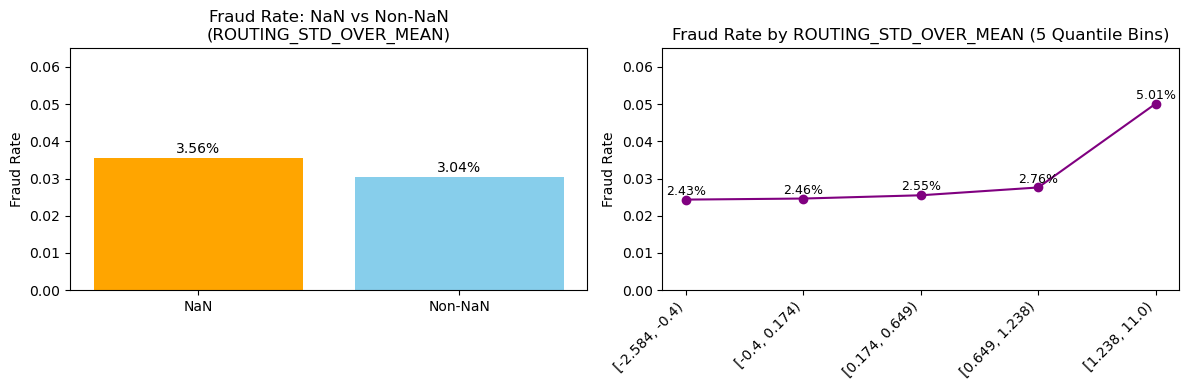

In [23]:
visualize_fraud_rate_numerical(training, 'ROUTING_STD_OVER_MEAN', 'FRAUD_FLG_TARGET')

In [25]:
def visualize_fraud_rate_categorical(df: pd.DataFrame, feature: str, target: str):
    """
    Plot fraud rate for each category of a categorical feature (including NaN as its own bar).

    Parameters
    ----------
    df : pd.DataFrame
    feature : str   # categorical column, can have NaN
    target : str    # binary target, 1 = fraud
    """
    tmp = df[[feature, target]].copy()

    # make NaN explicit so we can groupby it
    tmp[feature] = tmp[feature].astype("object")
    tmp[feature] = tmp[feature].where(tmp[feature].notna(), "NaN")

    # fraud rate per category
    grp = tmp.groupby(feature)[target].agg(["mean", "count"]).reset_index()
    grp.rename(columns={"mean": "fraud_rate", "count": "n"}, inplace=True)

    # sort (optional): highest fraud rate first
    grp = grp.sort_values("fraud_rate", ascending=False)

    # y-limit with headroom
    max_rate = grp["fraud_rate"].max()
    y_max = max(0.05, max_rate * 1.25)
    y_max = min(1.0, y_max)

    plt.figure(figsize=(max(6, 0.7 * len(grp)), 4))
    plt.bar(grp[feature], grp["fraud_rate"])
    plt.ylim(0, y_max)
    plt.ylabel("Fraud Rate")
    plt.title(f"Fraud Rate by {feature}")

    # put % on top of bars
    for i, (cat, rate, n) in enumerate(zip(grp[feature], grp["fraud_rate"], grp["n"])):
        plt.text(i, rate + y_max*0.015, f"{rate:.2%}\n(n={n})", ha="center", va="bottom", fontsize=8)

    plt.xticks(rotation=35, ha="right")
    plt.tight_layout()
    plt.show()


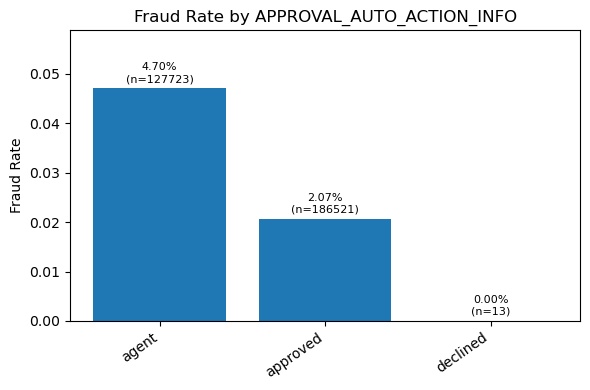

In [26]:
visualize_fraud_rate_categorical(training, "APPROVAL_AUTO_ACTION_INFO", "FRAUD_FLG_TARGET")